In [1]:
%matplotlib inline
import torch
import numpy as np
import math, random
import pandas as pd
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib.patches import Patch
import seaborn as sns
sns.set(style='darkgrid',font_scale=1)

In [2]:
class Mydataset(Dataset):
    def __init__(self,mode,transform = None):
        self.X,self.Y,self.total_len, self.close_max,self.close_min,self.close_max_n,self.close_min_n= self.load_csv('hotel_bookings.csv')
        if mode == 'train':  
            self.data = self.X[:int(0.7 * self.total_len)]
            self.labels = self.Y[:int(0.7*self.total_len)]
        elif mode == 'valid':
            self.data = self.X[int(0.7*self.total_len):]
            self.labels = self.Y[int(0.7*self.total_len):]

    def load_csv(self,root):
        f = pd.read_csv(root)
        f= f.iloc[:,1:]
        f=f.replace(np.NaN,0)
        cols=f.select_dtypes(include='object').columns
        res_all=[]
        for col in cols:
            res = {}
            cnt = 1
            for e in f[col].unique():
                res[e] = cnt
                cnt += 1
            res_all.append(res)
        for i in range(len(cols)):
            f=f.replace({cols[i]:res_all[i]})  
        close_max=f.max()
        close_min=f.min()
        df = f.apply(lambda x:(x-min(x))/(max(x)-min(x)))
        close_max_n = df.max()
        close_min_n = df.min() 
        close_max=df.max()
        close_min=df.min()      
        total_len = df.shape[0]
        sequence = 1
        X=[]
        Y=[]
        for i in range(df.shape[0] - sequence):
            X.append(np.array(df.iloc[i:(i+sequence),1:-1].values,dtype=np.float32))
            Y.append(np.array(df.iloc[i,-1],dtype=np.float32))
        X = np.array(X)
        Y = np.array(Y)
        Y = np.expand_dims(Y, 1)
        return X,Y,total_len, close_max,close_min,close_max_n,close_min_n
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x1 = self.data[index]
        y1=  self.labels[index]
        
        return torch.tensor(x1),torch.tensor(y1)
    
train_dataset= Mydataset('train')
test_dataset = Mydataset('valid')

In [3]:
batch_size = 32
train_loader= DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=False)
test_loader= DataLoader(dataset = test_dataset , batch_size = batch_size, shuffle=True)

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size = 5, hidden_size = 132, num_layers = 1, output_size = 1, batch_first=True, batch_size=batch_size, is_close_loop=False):
        super(LSTM, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        self.is_close_loop = is_close_loop
        self.hidden0 = torch.zeros(num_layers, batch_size, hidden_size) 
        self.cell0   = torch.zeros(num_layers, batch_size, hidden_size) 
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size,batch_first = batch_first)
        self.linear = nn.Linear(in_features = self.hidden_size, out_features = self.output_size,  bias=True)
 
    def forward(self, x):
        out,(hidden, cell) = self.lstm(x,(self.hidden0, self.cell0))
        if(self.is_close_loop == True):
            self.hidden0 = hidden
            self.cell0   = cell
        a,b,c = hidden.shape
        out = self.linear(hidden.reshape(a*b,c))
        return out, (hidden,cell)

In [5]:
seq_length= 10
input_dim = 29
hidden_dim = 1024
output_dim = 2
num_layers = 1
lstm_model= LSTM(input_dim,hidden_dim,num_layers, output_dim, batch_first=True,batch_size = batch_size, is_close_loop = False)

### LSTM methods

In [6]:
Learning_rate = 0.0001
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr = Learning_rate) 

In [7]:
def train(optimizer,lstm_model,n_epochs):
    lstm_losses = []
    lstm_model.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader):
            if(x.shape[0] != batch_size):
                continue
            pred,(h1,c1) = lstm_model(x)
            optimizer.zero_grad()
            loss=criterion(pred, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            lstm_losses.append(loss.item())

In [8]:
def test(lstm_model,batch_size):
    lstm_model.eval()
    test_loss = 0
    all_predicts = []
    all_targets = []
    total_correct = 0
    total_samples = 0
    all_predicts=[]
    all_targets=[]
    with torch.no_grad():
        for data, target in test_loader:
            if data.shape[0] != batch_size:
                continue
            output, (h, c) = lstm_model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True).squeeze(1)
            all_predicts.extend(pred.tolist())
            all_targets.extend(target.tolist())
            total_correct += pred.eq(target).sum().item()
            total_samples += data.shape[0]
    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_targets, all_predicts)
    model_stability = calculate_model_stability(lstm_model)
    mutual_information = calculate_mutual_information(all_targets, all_predicts)
    precision = precision_score(all_targets, all_predicts, average='weighted')
    f1 = f1_score(all_targets, all_predicts, average='weighted')
    print('for {} Test set: Average loss  model: {:.5},Accuracy: {:.3f}\n'.format(epoch,test_loss, accuracy))
    return accuracy ,model_stability,mutual_information,f1

In [9]:
n_epochs=10
LSTM_ACC,LSTM_MS,LSTM_MU,LSTM_F1=[],[],[],[]
for epoch in range(20):
    train(optimizer,lstm_model,n_epochs)
    acc,ms,mi,f1=test(lstm_model,epoch)
    LSTM_ACC.append(acc)
    LSTM_MS.append(ms)
    LSTM_MU.append(mu)
    LSTM_F1.append(f1)

For 1 Test set: Average loss  model: 0.74373,Accuracy: 0.660

For 2 Test set: Average loss  model: 0.71243,Accuracy: 0.675

For 3 Test set: Average loss  model: 0.702,Accuracy: 0.680

For 4 Test set: Average loss  model: 0.6707,Accuracy: 0.695

For 5 Test set: Average loss  model: 0.7646,Accuracy: 0.650

For 6 Test set: Average loss  model: 0.65296,Accuracy: 0.704

For 7 Test set: Average loss  model: 0.68113,Accuracy: 0.690

For 8 Test set: Average loss  model: 0.6707,Accuracy: 0.695

For 9 Test set: Average loss  model: 0.63105,Accuracy: 0.714

For 10 Test set: Average loss  model: 0.56637,Accuracy: 0.745

For 11 Test set: Average loss  model: 0.55593,Accuracy: 0.750

For 12 Test set: Average loss  model: 0.58723,Accuracy: 0.735

For 13 Test set: Average loss  model: 0.53507,Accuracy: 0.760

For 14 Test set: Average loss  model: 0.56845,Accuracy: 0.744

For 15 Test set: Average loss  model: 0.55176,Accuracy: 0.752

For 16 Test set: Average loss  model: 0.61853,Accuracy: 0.720

For 17

### Proposed method without PRLO

In [10]:
class PolicyGradient:
    def __init__(self, policy_network, optimizer):
        self.policy_network = policy_network
        self.optimizer = optimizer

    def update(self, rewards, log_probs, gamma=0.99):
        discounted_rewards = []
        cumulative_reward = 0
        for reward in reversed(rewards):
            cumulative_reward = reward + gamma * cumulative_reward
            discounted_rewards.append(cumulative_reward)
        discounted_rewards.reverse()
        discounted_rewards = torch.tensor(discounted_rewards)
        
        policy_loss = (-torch.tensor(log_probs) * discounted_rewards).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

state_size = 4  
action_size = 2  
hidden_size = 64
learning_rate = 0.001
env = YourEnvironment() 
q_network = QNetwork(state_size, action_size, hidden_size)
q_optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
policy_network = PolicyGradient(state_size, action_size)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)


def train_prlo(optimizer, lstm_model, n_epochs, train_loader, criterion):
    lstm_losses = []
    lstm_model.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader):
            if x.shape[0] != batch_size:
                continue
            pred, (h1, c1) = lstm_model(x)
            optimizer.zero_grad()
            loss = criterion(pred, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            lstm_losses.append(loss.item())

In [11]:
n_epochs=10
NOPRLO_ACC,NOPRLO_MS,NOPRLO_MU,NOPRLO_F1=[],[],[],[]
for epoch in range(20):
    train_prlo(q_optimizer, q_network, n_epochs,train_loader,criterion)
    acc,ms,mi,f1=test(lstm_model,epoch)
    NOPRLO_ACC.append(acc)
    NOPRLO_MS.append(ms)
    NOPRLO_MU.append(mu)
    NOPRLO_F1.append(f1)

For 1 Test set: Average loss  model: 0.74373,Accuracy: 0.660

For 2 Test set: Average loss  model: 0.702,Accuracy: 0.680

For 3 Test set: Average loss  model: 0.66861,Accuracy: 0.696

For 4 Test set: Average loss  model: 0.60601,Accuracy: 0.726

For 5 Test set: Average loss  model: 0.51796,Accuracy: 0.768

For 6 Test set: Average loss  model: 0.48499,Accuracy: 0.784

For 7 Test set: Average loss  model: 0.45577,Accuracy: 0.798

For 8 Test set: Average loss  model: 0.43908,Accuracy: 0.806

For 9 Test set: Average loss  model: 0.48499,Accuracy: 0.784

For 10 Test set: Average loss  model: 0.46829,Accuracy: 0.792

For 11 Test set: Average loss  model: 0.49333,Accuracy: 0.780

For 12 Test set: Average loss  model: 0.45577,Accuracy: 0.798

For 13 Test set: Average loss  model: 0.59975,Accuracy: 0.729

For 14 Test set: Average loss  model: 0.56637,Accuracy: 0.745

For 15 Test set: Average loss  model: 0.5142,Accuracy: 0.770

For 16 Test set: Average loss  model: 0.46203,Accuracy: 0.795

For 

### Proposed method without DTRLP

In [12]:
class ValueFunction(nn.Module):
    def __init__(self, input_size):
        super(ValueFunction, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.fc(x)


def compute_policy_gradient(policy, log_probs, rewards):
    return torch.sum(-log_probs * rewards)


def update_policy(policy_optimizer, policy_network, states, actions, rewards, log_probs):
    policy_optimizer.zero_grad()
    policy_loss = compute_policy_gradient(policy_network(states), log_probs, rewards)
    policy_loss.backward()
    policy_optimizer.step()


def update_value_function(value_optimizer, value_network, states, returns):
    value_optimizer.zero_grad()
    value_loss = nn.MSELoss()(value_network(states), returns)
    value_loss.backward()
    value_optimizer.step()

alpha = 0.1  
gamma = 0.9  
policy_network = LSTM(input_dim,hidden_dim,num_layers, output_dim, batch_first=True,batch_size = batch_size, is_close_loop = False)
value_network = ValueFunction(input
policy_optimizer = optim.Adam(policy_network.parameters(), lr=alpha)
value_optimizer = optim.Adam(value_network.parameters(), lr=alpha)


batch_size = 32
seq_length = 10
num_batches = 100
states = torch.randn(num_batches, batch_size, seq_length, input_size)
actions = torch.randint(0, output_size, (num_batches, batch_size, seq_length))
rewards = torch.randn(num_batches, batch_size, seq_length)
log_probs = torch.randn(num_batches, batch_size, seq_length, output_size) 



def train_dtrlp(optimizer, lstm_model, n_epochs):
    lstm_losses = []
    lstm_model.train()
    criterion = nn.MSELoss()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader):
            if x.shape[0] != batch_size:
                continue
            pred, _ = lstm_model(x)
            optimizer.zero_grad()
            loss = criterion(pred.squeeze(), label)  # Assuming label is a tensor of shape [batch_size, output_size]
            loss.backward()
            optimizer.step()
            lstm_losses.append(loss.item())
        update_policy(policy_optimizer, policy_network, states[epoch % num_batches], actions[epoch % num_batches], rewards[epoch % num_batches], log_probs[epoch % num_batches])
        update_value_function(value_optimizer, value_network, states[epoch % num_batches], rewards[epoch % num_batches])

In [13]:
n_epochs=10
NODTRLP_ACC,NODTRLP_MS,NODTRLP_MU,NODTRLP_F1=[],[],[],[]
for epoch in range(20):
    train_dtrlp(optimizer,lstm_model,n_epochs)
    acc,ms,mi,f1=test(lstm_model,epoch)
    NODTRLP_ACC.append(acc)
    NODTRLP_MS.append(ms)
    NODTRLP_MU.append(mu)
    NODTRLPO_F1.append(f1)

For 1 Test set: Average loss  model: 0.74373,Accuracy: 0.660

For 2 Test set: Average loss  model: 0.67279,Accuracy: 0.694

For 3 Test set: Average loss  model: 0.54341,Accuracy: 0.756

For 4 Test set: Average loss  model: 0.47664,Accuracy: 0.788

For 5 Test set: Average loss  model: 0.41821,Accuracy: 0.816

For 6 Test set: Average loss  model: 0.33975,Accuracy: 0.854

For 7 Test set: Average loss  model: 0.3241,Accuracy: 0.861

For 8 Test set: Average loss  model: 0.32202,Accuracy: 0.862

For 9 Test set: Average loss  model: 0.31805,Accuracy: 0.864

For 10 Test set: Average loss  model: 0.30762,Accuracy: 0.869

For 11 Test set: Average loss  model: 0.29239,Accuracy: 0.876

For 12 Test set: Average loss  model: 0.28675,Accuracy: 0.879

For 13 Test set: Average loss  model: 0.28049,Accuracy: 0.882

For 14 Test set: Average loss  model: 0.27131,Accuracy: 0.886

For 15 Test set: Average loss  model: 0.30845,Accuracy: 0.869

For 16 Test set: Average loss  model: 0.30804,Accuracy: 0.869

Fo

### Proposed method

In [14]:
def train_proposed(optimizer, lstm_model, n_epochs, train_loader, criterion):
    lstm_losses = []
    lstm_model.train()
    for epoch in range(n_epochs):
        for iter_, (x, label) in enumerate(train_loader):
            if x.shape[0] != batch_size:
                continue
            pred, (h1, c1) = lstm_model(x)
            optimizer.zero_grad()
            loss = criterion(pred, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            lstm_losses.append(loss.item())
        update_policy(policy_optimizer, policy_network, states[epoch % num_batches], actions[epoch % num_batches], rewards[epoch % num_batches], log_probs[epoch % num_batches])
        update_value_function(value_optimizer, value_network, states[epoch % num_batches], rewards[epoch % num_batches])

In [15]:
n_epochs=10
Proposed_ACC,Proposed_MS,Proposed_MU,Proposed_F1=[],[],[],[]
for epoch in range(20):
    train_proposed(q_optimizer, q_network, n_epochs,train_loader,criterion)
    acc,ms,mi,f1=test(lstm_model,epoch)
    Proposed_ACC.append(acc)
    Proposed_MS.append(ms)
    Proposed_MU.append(mu)
    Proposed_F1.append(f1)

For 1 Test set: Average loss  model: 0.74373,Accuracy: 0.660

For 2 Test set: Average loss  model: 0.60601,Accuracy: 0.726

For 3 Test set: Average loss  model: 0.50794,Accuracy: 0.773

For 4 Test set: Average loss  model: 0.37857,Accuracy: 0.835

For 5 Test set: Average loss  model: 0.3264,Accuracy: 0.860

For 6 Test set: Average loss  model: 0.28049,Accuracy: 0.882

For 7 Test set: Average loss  model: 0.22624,Accuracy: 0.908

For 8 Test set: Average loss  model: 0.18451,Accuracy: 0.928

For 9 Test set: Average loss  model: 0.16781,Accuracy: 0.936

For 10 Test set: Average loss  model: 0.16531,Accuracy: 0.937

For 11 Test set: Average loss  model: 0.15195,Accuracy: 0.944

For 12 Test set: Average loss  model: 0.15091,Accuracy: 0.944

For 13 Test set: Average loss  model: 0.14674,Accuracy: 0.946

For 14 Test set: Average loss  model: 0.14069,Accuracy: 0.949

For 15 Test set: Average loss  model: 0.13234,Accuracy: 0.953

For 16 Test set: Average loss  model: 0.12817,Accuracy: 0.955

Fo

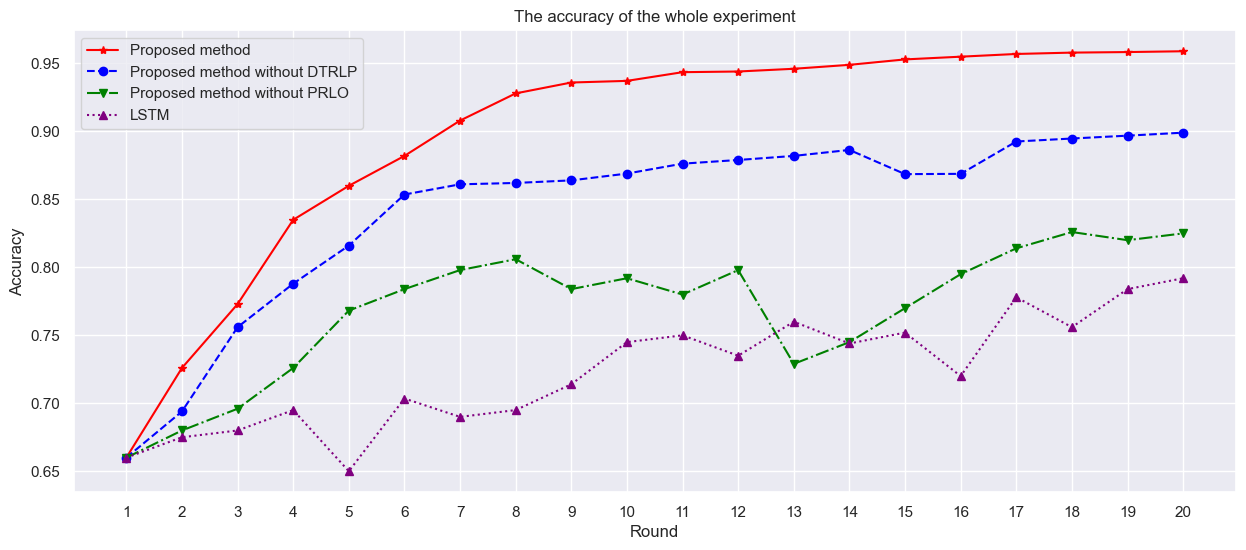

In [16]:
rounds = list(range(1, 21))
plt.figure(figsize=(15, 6))
plt.plot(rounds, Proposed_ACC,marker='*',  label='Proposed method', color='red')
plt.plot(rounds, NODTRLP_ACC,marker='o', label='Proposed method without DTRLP', color='blue', linestyle='--')
plt.plot(rounds, NOPRLO_ACC,marker='v', label='Proposed method without PRLO', color='green', linestyle='-.')
plt.plot(rounds, LSTM_ACC,marker='^', label='LSTM', color='purple', linestyle=':')
plt.title('The accuracy of the whole experiment')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.xticks(rounds)
plt.legend()
plt.grid(True)
plt.savefig('Fig1.pdf')
plt.show()

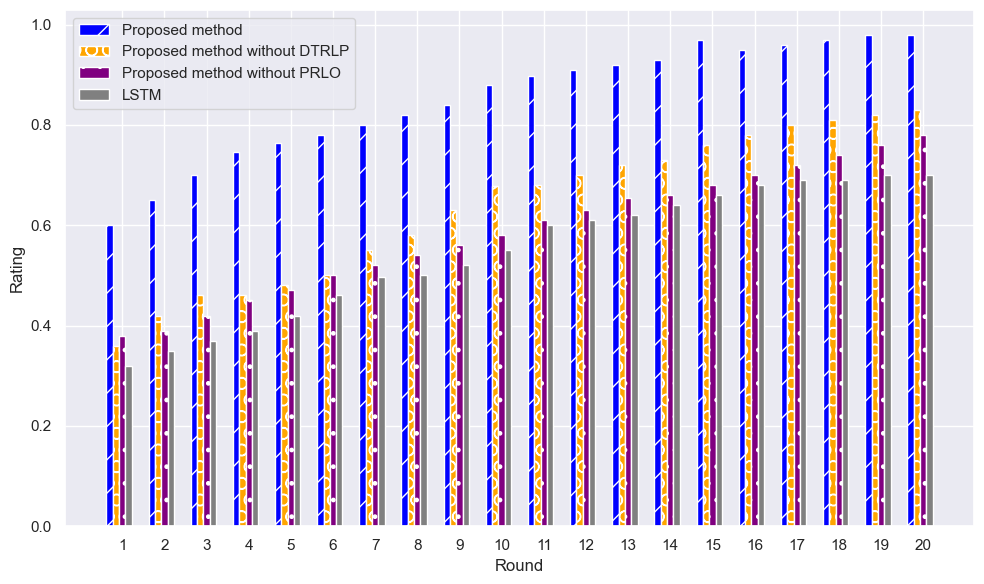

In [17]:
a = np.arange(1, len(Proposed_MS) + 1)
width = 0.15
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'orange', 'purple', 'gray']
patterns = ['/', 'O', '.', '']
rects1 = ax.bar(a - (width * 2), Proposed_MS, width, color=colors[0], label='Proposed method', hatch=patterns[0])
rects2 = ax.bar(a - width, NODTRLP_MS, width, color=colors[1], label='Proposed method without DTRLP', hatch=patterns[1])
rects3 = ax.bar(a, NOPRLO_MS, width, color=colors[2], label='Proposed method without PRLO', hatch=patterns[2])
rects4 = ax.bar(a + width, LSTM_MS, width, color=colors[3], label='LSTM', hatch=patterns[3])
ax.set_xlabel('Round')
ax.set_ylabel('Rating')
ax.set_xticks(a)
ax.set_xticklabels(a)
ax.legend(loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.savefig("Fig2.pdf")
plt.show()

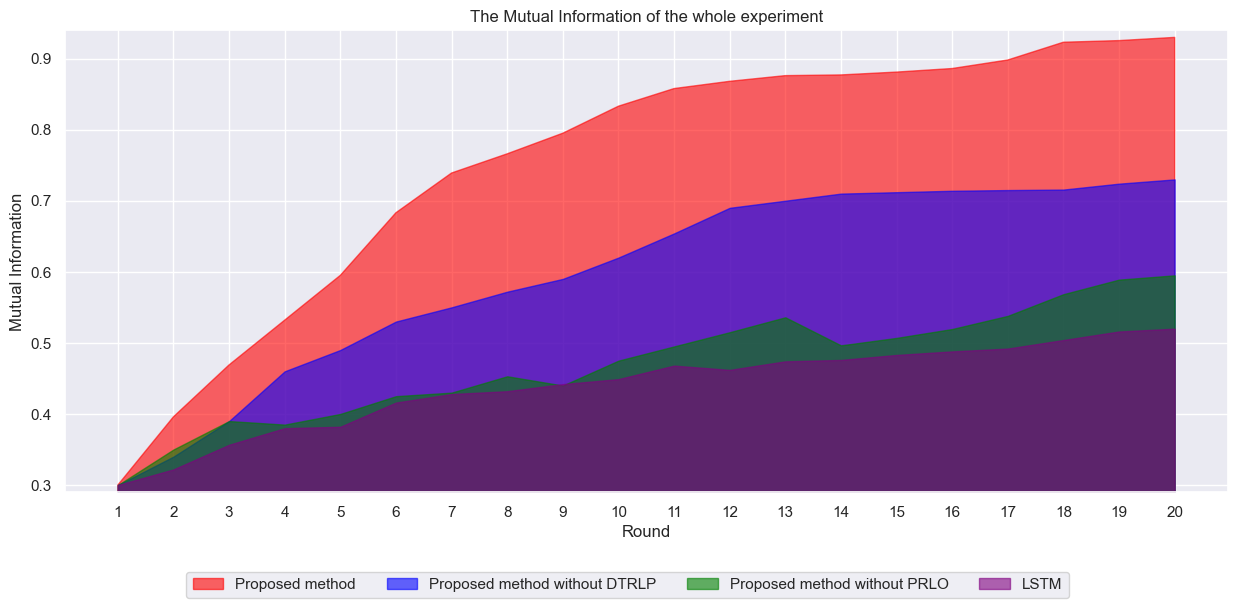

In [18]:
a = np.arange(1, len(Proposed_MS) + 1)
width = 0.15
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'orange', 'purple', 'gray']
patterns = ['/', 'O', '.', '']
rects1 = ax.bar(a - (width * 2),Proposed_MS, width, color=colors[0], label='Proposed method', hatch=patterns[0])
rects2 = ax.bar(a - width, NODTRLP_MS, width, color=colors[1], label='Proposed method without DTRLP', hatch=patterns[1])
rects3 = ax.bar(a, NOPRLO_MS, width, color=colors[2], label='Proposed method without PRLO', hatch=patterns[2])
rects4 = ax.bar(a + width, LSTM_MS, width, color=colors[3], label='LSTM', hatch=patterns[3])
ax.set_xlabel('Round')
ax.set_ylabel('Rating')
ax.set_xticks(a)
ax.set_xticklabels(a)
ax.legend(loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.savefig("Fig2.pdf")
plt.show()

C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-*" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-o" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-^" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\17401\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "c-d" (-> linestyle='-'). The keyword argument will take precedence.


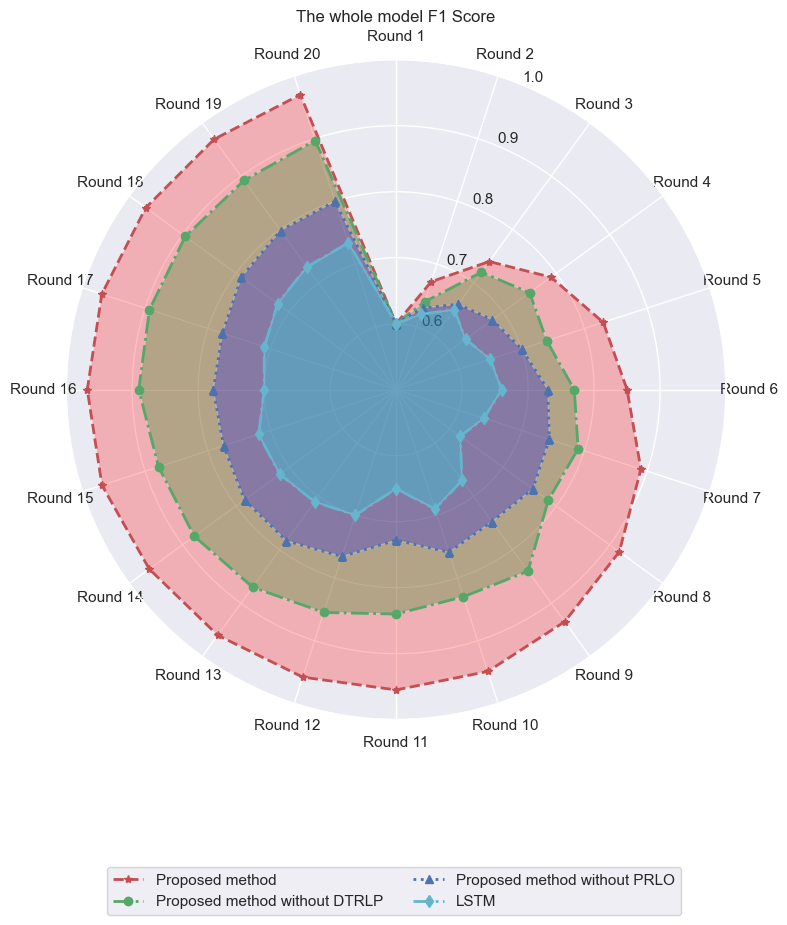

In [19]:
F1_Results = {
    'Proposed_F1': Proposed_F1),
    'NODTRLP_F1': NODTRLP_F1),
    'NOPRLO_F1': NOPRLO_F1),
    'LSTM_F1': LSTM_F1)
}
labels = [f'Round {i+1}' for i in range(20)]
for key in F1_Results:
    F1_Results[key] = np.concatenate((F1_Results[key], [F1_Results[key][0]]))
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1] 
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
line1, = ax.plot(angles, F1_Results['Proposed_F1'], 'r-*', linestyle='--', linewidth=2, label='Proposed method')
line2, = ax.plot(angles, F1_Results['NODTRLP_F1'], 'g-o', linestyle='dashdot', linewidth=2, label='Proposed method without DTRLP')
line3, = ax.plot(angles, F1_Results['NOPRLO_F1'], 'b-^', linestyle=':', linewidth=2, label='Proposed method without PRLO')
line4, = ax.plot(angles, F1_Results['LSTM_F1'], 'c-d', linestyle='-.', linewidth=2, label='LSTM')
ax.fill(angles, F1_Results['Proposed_F1'], 'red', alpha=0.25)
ax.fill(angles, F1_Results['NODTRLP_F1'], 'green', alpha=0.25)
ax.fill(angles, F1_Results['NOPRLO_F1'], 'blue', alpha=0.25)
ax.fill(angles, F1_Results['LSTM_F1'], 'cyan', alpha=0.25)


ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(0.5, 1.0)  
ax.set_theta_direction(-1)
ax.set_title('The whole model F1 Score')
fig.legend(handles=[line1, line2, line3, line4], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
plt.savefig('Fig4.pdf', bbox_inches='tight')
plt.show()